## **Load in data**

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pylab
import dateutil.parser as dp
from sklearn import preprocessing
from scipy.optimize import minimize
from GP import * 



data_url = 'http://www.robots.ox.ac.uk/~mosb/teaching/AIMS_CDT/sotonmet.txt'
data = pd.read_csv(data_url)

print(data.columns)

# Time in days since first reading
t = data['Reading Date and Time (ISO)']
t = [int(dp.parse(x).strftime('%s')) for x in t]
t = np.array([float(x - t[0])/86400 for x in t]).reshape(-1,1)

# Training and test data
y = data['Tide height (m)']
ytrue = data['True tide height (m)']

# Remove missing data points
data_train = [(t[i], y[i]) for i in range(len(t)) if not np.isnan(y[i])]
data_test = [(t[i], ytrue[i]) for i in range(len(t)) if not np.isnan(ytrue[i])]
t, y = [x[0] for x in data_train], [x[1] for x in data_train]
ttrue, ytrue = [x[0] for x in data_test], [x[1] for x in data_test]

# Normalise both datasetts
mean, stdev = np.mean(y), np.std(y)
y = np.array([(yi - mean) / stdev for yi in y]).reshape(-1,1)
ytrue = np.array([(yi - mean) / stdev for yi in ytrue]).reshape(-1,1)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['Update Date and Time (ISO)', 'Update Duration (ms)',
       'Reading Date and Time (ISO)', 'Air pressure (mb)',
       'Air temperature (C)', 'Tide height (m)', 'Wind direction (deg)',
       'Wind gust speed (kn)', 'Wind speed (kn)', 'True air temperature (C)',
       'True tide height (m)', 'Independent tide height prediction (m)',
       'Independent tide height deviation (m)',
       'Dependent tide height prediction (m)',
       'Dependent tide height deviation (m)',
       'Independent air temperature prediction (C)',
       'Independent air temperature deviation (C)',
       'Dependent air temperature prediction (C)',
       'Dependent air temperature deviation (C)'],
      dtype='object')


## **Initial Test**

Hyperparameters chosen manually to provide a reasonable fit to the data, using a summed RBF kernel and periodic kernel.


Log marginal likelihood: 224.24338050729114


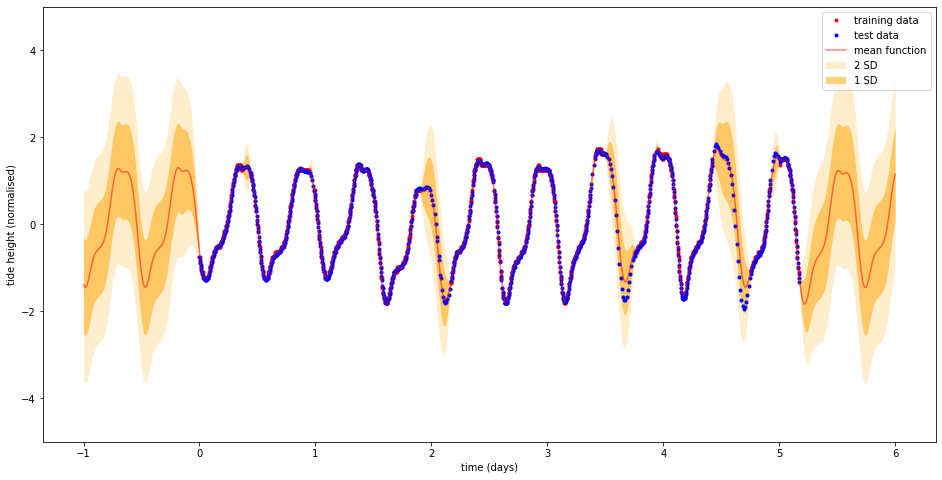

In [13]:
# Plot width and height in inches
width, height = 16, 8
pylab.rcParams['figure.figsize'] = width, height

# Initial guess for model parameters
# sigma_rbf = 1.0
# L_rbf = 0.2

# sigma_per = 1
# L_per = 0.4
# p_per = 0.5175

# jitter = 0.1
jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per = 0.02313429 -0.32364286  0.46129201  0.62726026  0.80954964  0.51560234


# Build the kernel (additive: RBF + periodic)
kernel = Kernel()
kernel.addKernel("RBF", sigma_rbf, L_rbf)
kernel.addKernel("periodic", sigma_per, L_per, p_per)

# input data
# points = 5
X = t
Y = y
Xs = np.linspace(-1, 6, 500).reshape(-1,1)


# mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

print("Log marginal likelihood:", LML)

# Uncertainties (sigma and 2sigma)
y1 = np.array([mu[i] + 2 * sigma[i][i] for i in range(len(Xs))]).ravel()
y2 = np.array([mu[i] - 2 * sigma[i][i] for i in range(len(Xs))]).ravel()
pylab.fill_between(Xs.ravel(), y1, y2, linewidth=0, color='orange', alpha=0.2, label='2 SD')
y1 = np.array([mu[i] + 1 * sigma[i][i] for i in range(len(Xs))]).ravel()
y2 = np.array([mu[i] - 1 * sigma[i][i] for i in range(len(Xs))]).ravel()
pylab.fill_between(Xs.ravel(), y1, y2, linewidth=0, color='orange', alpha=0.5, label='1 SD')

# measurements and truth data
pylab.plot(t, y, '.r', label='training data')
pylab.plot(ttrue, ytrue, '.b', label='test data')

# mean function
pylab.plot(Xs, mu, '-r', alpha=0.5, label='mean function')

# function draws
draws = 0
for i in range(draws):
    fs = getFunctionSample(mu, sigma)
    pylab.plot(Xs, fs, color='green', alpha=0.3, label='function draws')

pylab.legend(loc='upper right')
pylab.xlabel('time (days)')
pylab.ylabel('tide height (normalised)')
pylab.ylim((-5, 5))
# pylab.xlim((3,4))

pylab.show()

## Optimisation of Log Marginal Likelihood


In [14]:
# Plot width and height in inches
width, height = 16, 8
pylab.rcParams['figure.figsize'] = width, height

# Input data
X = t
Y = y
Xs = np.linspace(-1, 6, 500).reshape(-1,1)

# Initial guess for model parameters
jitter = 0.1

sigma_rbf = 1.0 # RBF kernel
L_rbf = 0.2

sigma_per = 1.  # periodic kernel
L_per = 0.4
p_per = 0.5175


X0 = np.array([jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per]).T

max_iter = 10
result = minimize(
    optimizerFunction, 
    X0, 
    args=(X, Y, Xs), 
    method='BFGS', 
    tol=0.01,
    options={"maxiter":max_iter, "disp":True})
# optimize.minimize(

print("X0: ", X0)
    
print("X:", result.x)


# # Points of interest
# mu, sigma, LML = GetPosteriorPredictive(X, Y, Xs, kernel, jitter)

# print("Log marginal likelihood:", LML)

# # Uncertainties (sigma and 2sigma)
# y1 = np.array([mu[i] + 2 * sigma[i][i] for i in range(len(Xs))])
# y2 = np.array([mu[i] - 2 * sigma[i][i] for i in range(len(Xs))])
# pylab.fill_between(Xs.ravel(), y1, y2, linewidth=0, color='blue', alpha=0.1, label='2 SD')
# y1 = np.array([mu[i] + 1 * sigma[i][i] for i in range(len(Xs))])
# y2 = np.array([mu[i] - 1 * sigma[i][i] for i in range(len(Xs))])
# pylab.fill_between(Xs.ravel(), y1, y2, linewidth=0, color='blue', alpha=0.2, label='1 SD')

# # measurements and truth data
# pylab.plot(t, y, '.r', label='training data')
# pylab.plot(ttrue, ytrue, '.b', label='test data')

# # mean function
# pylab.plot(Xs, mu, '-r', alpha=0.5, label='mean function')

# # function draws
# draws = 0
# for i in range(draws):
#     fs = getFunctionSample(mu, sigma)
#     pylab.plot(Xs, fs, color='green', alpha=0.3, label='function draws')

# pylab.legend(loc='upper right')
# pylab.xlabel('time (days)')
# pylab.ylabel('tide height (normalised)')
# pylab.ylim((-5, 5))
# # pylab.xlim((3,4))

# pylab.show()

LML: 224.24338050729114
LML: 224.243353756308
LML: 224.24337015262188
LML: 224.24342981444477
LML: 224.24338034812888
LML: 224.24338159513115
LML: 224.2433725575596
LML: -756.2210530476767
LML: -756.221037060034
LML: -756.221035535426
LML: -756.2210665152083
LML: -756.2210533116556
LML: -756.2210518916125
LML: -756.2210567253403
LML: 826.3410587618599
LML: 826.3410880654909
LML: 826.3410515016568
LML: 826.3410751695084
LML: 826.3410584743698
LML: 826.3410603543942
LML: 826.3410871316511
LML: 233.28085484878613
LML: 233.28077400796371
LML: 233.28087525586636
LML: 233.2808354153177
LML: 233.28085456641531
LML: 233.28085636155936
LML: 233.28082116851613
LML: 970.9540010191605
LML: 970.9539704325404
LML: 970.9539975945871
LML: 970.9540067286431
LML: 970.9540007490306
LML: 970.9540026927024
LML: 970.9539298227088
LML: 1092.7499870171487
LML: 1092.7499980704806
LML: 1092.7499761285749
LML: 1092.7500075658095
LML: 1092.7499868220166
LML: 1092.74998874102
LML: 1092.7499800218302
LML: 79.569337